# Part 1 - EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## Response to Part 1

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib.dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Load dataset
df_logins = pd.read_json('logins.json', convert_dates=True)

#### Explore initial data set

In [3]:
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
df_logins.isnull().sum()

login_time    0
dtype: int64

In [6]:
df_logins['login_time'].describe()

count                   93142
unique                  92265
top       1970-03-17 01:01:39
freq                        3
first     1970-01-01 20:12:16
last      1970-04-13 18:57:38
Name: login_time, dtype: object

**Insight:** Preliminary analysis has revealed approximately 900 duplicate values present in the dataset, with the highest duplication frequency rate of 3. Due to the lack of information concerning the data collection process, there is a possibility that these duplications are not errors but may have occurred organically. Further analysis would be required to determine if these duplications need to be addressed.

#### Resampling dataset in 15 minute intervals and aggregating by count

In [7]:
#Set 'login_time' as the DataFrame index
df_logins.set_index('login_time', inplace=True)

In [8]:
df_logins['Count'] = 0

#Resample and count logins in 15-minute intervals
df = df_logins.resample('15T').count()

#Reset index to have 'login_time' as a column
df.reset_index(inplace=True)

#Rename the 'login_time' column to 'logins'
df.rename(columns={'login_time': 'Logins'}, inplace=True)

df.head()

,Logins,Count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


#### Further aggregating data to allow for clearer analysis

In [9]:
#Extract days and hours
df['Day'] = df['Logins'].dt.day_name()
df['Hour'] = df['Logins'].dt.hour

#Check the result
df.head()

,Logins,Count,Day,Hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [10]:
#Creating order for mapping
day_order = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

In [11]:
#Mapping and sorting data
df['Day_numeric'] = df['Day'].map(day_order)

df_sorted = df.sort_values(by='Day_numeric')

In [12]:
df_sorted.head()

,Logins,Count,Day,Hour,Day_numeric
9787,1970-04-13 18:45:00,6,Monday,18,1
2387,1970-01-26 16:45:00,10,Monday,16,1
2386,1970-01-26 16:30:00,3,Monday,16,1
2385,1970-01-26 16:15:00,6,Monday,16,1
2384,1970-01-26 16:00:00,1,Monday,16,1


#### Analyzing data on a day of the week basis

In [13]:
#Average daily logins per hour
df_total = df_sorted.groupby(['Hour','Day']).mean().reset_index()

In [14]:
df_total_sorted = df_total.sort_values(by='Day_numeric')
df_total_sorted.head()

,Hour,Day,Count,Day_numeric
85,12,Monday,12.033333,1.0
113,16,Monday,4.150000,1.0
64,9,Monday,4.266667,1.0
29,4,Monday,3.433333,1.0
99,14,Monday,5.616667,1.0


#### Visualizing data

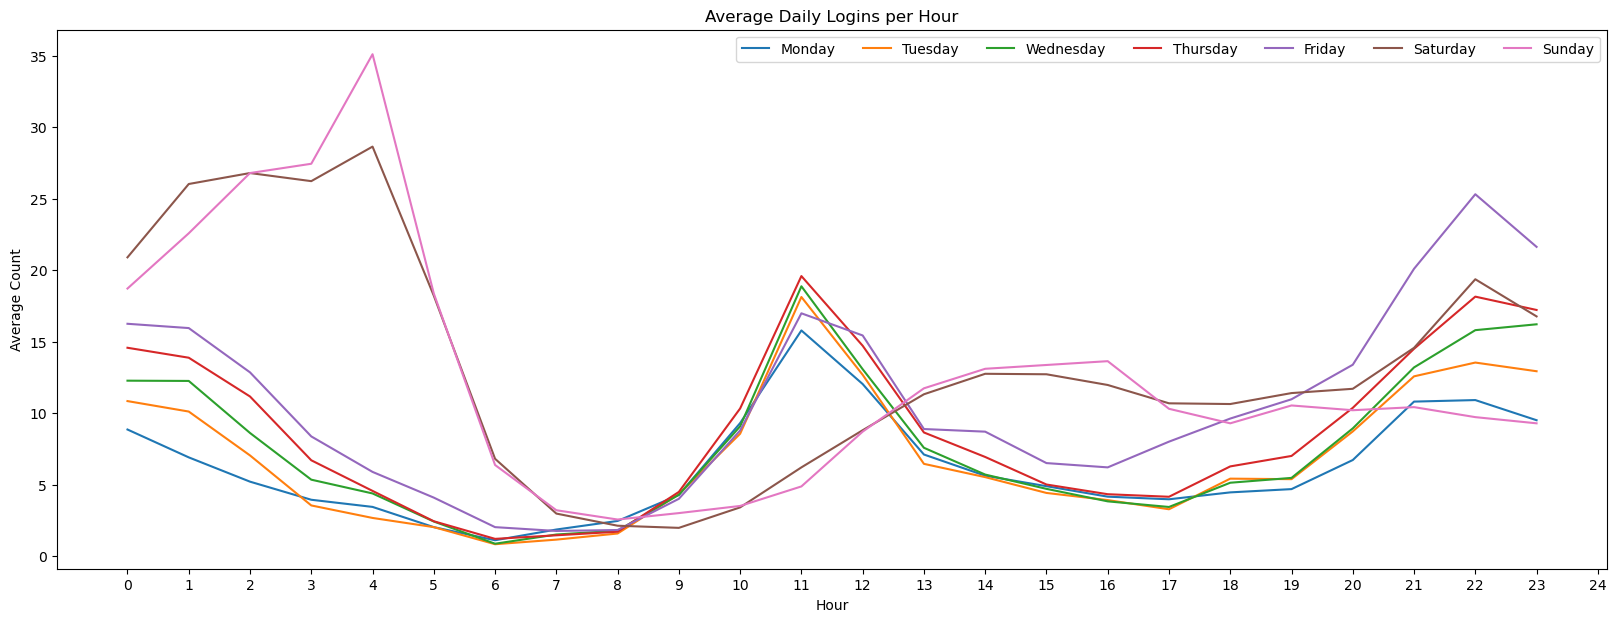

In [15]:
#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x='Hour', y='Count', data=df_total_sorted, hue='Day')
ax.legend(loc='upper right', ncol=8)
ax.set(title='Average Daily Logins per Hour', ylabel='Average Count')
plt.xticks(range(0,25))

#display plot
plt.show()

**Insight:** There are separate cyclical trends on weekdays and weekends, with weekday spikes occurring around 11:00 and 22:00, and weekend spikes overnight leading to a peak around 4:00. Both weekday and weekend averages show a lull between 6:00 and 9:00.

In [16]:
#Total logins per day of week
df_day = df.groupby('Day').sum()[['Count']]

#Average daily logins per day of week
df_day['Daily_avg'] = df_sorted.groupby('Day').mean()[['Count']]

df_day = df_day.reset_index()

df_day['Day_numeric'] = df_day['Day'].map(day_order)

df_day_sorted = df_day.sort_values(by='Day_numeric')

df_day_sorted.head(7)

,Day,Count,Daily_avg,Day_numeric
1,Monday,8823,6.213380,1
5,Tuesday,9268,6.895833,2
6,Wednesday,10339,7.692708,3
4,Thursday,11960,8.794118,4
0,Friday,15208,10.561111,5
2,Saturday,19377,13.456250,6
3,Sunday,18167,12.615972,7


**Insight:** Daily averages for weekends show almost double the number of logins compared to weekdays, with a general upward trend throughout the week. This trend can be seen in the graph below.

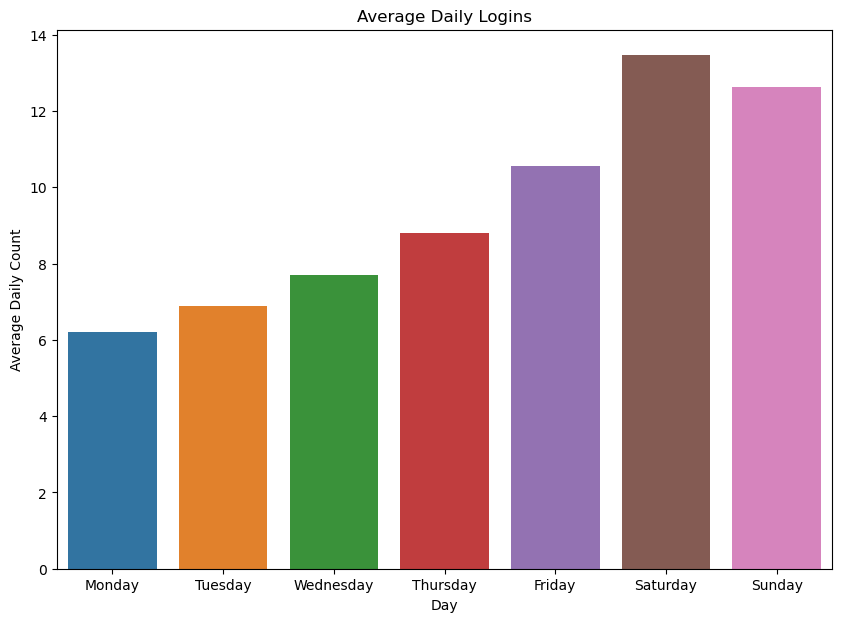

In [17]:
f, axes = plt.subplots(figsize=(10,7))
ax = sns.barplot(x='Day', y= 'Daily_avg', data=df_day_sorted)
ax.set(title='Average Daily Logins', ylabel='Average Daily Count')
plt.show()

#### Analyzing overall data set trends

In [18]:
#Resampling on daily intervals
df_daily = df_logins.resample('1D').count().reset_index()

#Cleaning dataframe
df_daily.index.name = 'idx'
df_daily.reset_index(inplace=True)
df_daily.rename({'login_time':'daily'}, axis=1, inplace=True)

#Extracting months
df_daily['month'] = df_daily['daily'].dt.month
df_daily['month'] = df_daily['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr'})


In [19]:
df_daily.head()

,idx,daily,Count,month
0,0,1970-01-01,112,Jan
1,1,1970-01-02,681,Jan
2,2,1970-01-03,793,Jan
3,3,1970-01-04,788,Jan
4,4,1970-01-05,459,Jan


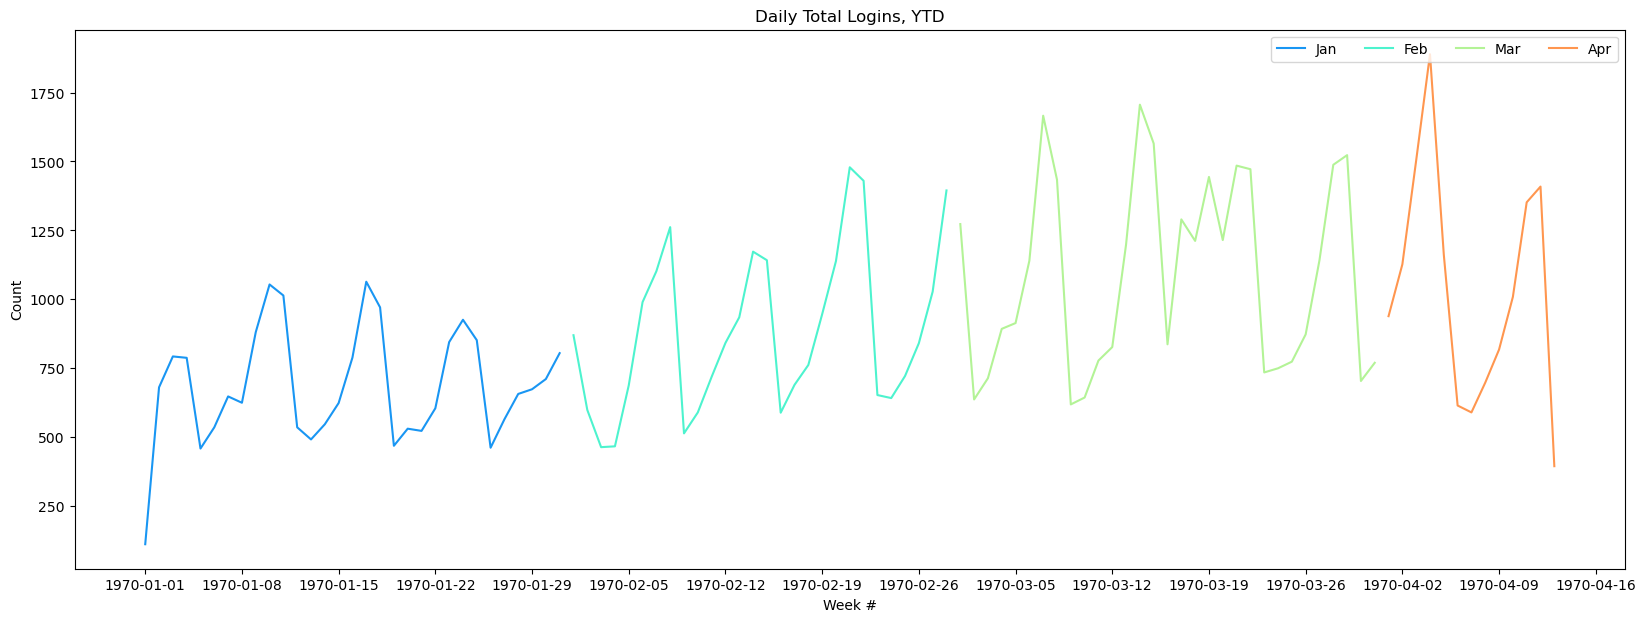

In [20]:
#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="daily", y="Count", data=df_daily, hue="month", palette="rainbow")
ax.legend(loc="upper right", ncol=5)
ax.set(title="Daily Total Logins, YTD", xlabel="Week #")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

#display plot
plt.show()

**Insight:** The graph illustrates a weekly cyclical trend with a consistent upward trajectory in logins over the available time period. Notably, there is a sharp decline in logins after the first week of April, however due to lack of information after that point it is hard to know if this is normal fluctuation or a signficant alteration to the trend. Additionally, an unusual deviation from the trend is observed during the week of 3/19, which could be attributed to factors like a holiday, possibly spring break, within the serviced area.

# Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

**1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

The primary metric to determine the success of this experiment that I would choose would be the percentage change in fares reported by city drivers where either the pickup or dropoff locations are outside their city of origin. This particular metric offers several advantages in assessing the effectiveness of the toll reimbursement initiative, while also mitigating potential biases that might arise from other measurement approaches. This metric is an excellent choice because it directly captures the behavioral change that the experiment seeks to promote. By monitoring instances where drivers cross city boundaries for pickups or dropoffs, we can ascertain if they are becoming more willing to serve both Gotham and Metropolis. However, unlike solely tracking toll counts or fare prices, this metric ensures a more comprehensive assessment of driver inclusivity. It takes into account all instances where drivers venture beyond their home city, regardless of the number of toll crossings or the fare amount. This approach eliminates potential blind spots in the evaluation process.

In summary, tracking the percentage increase in fares reported by city drivers involving cross-city pickups or dropoffs is a comprehensive, behavior-focused, and sustainable metric for evaluating the success of the toll reimbursement experiment. As it ensures that the experiment's objectives of promoting dual-city availability and reducing exclusivity are effectively met while accounting for weekend fluctuations and potential biases in other measurement approaches.

**2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**


**a) how you will implement the experiment**


**b) what statistical test(s) you will conduct to verify the significance of the observation**


**c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.**

### Experimental Design:

**a) Implementation of the Experiment:**
1. **Baseline Data Collection**: Before implementing the toll reimbursement policy, collect historical data for a specific period (e.g., 3 months) to establish a baseline. This data should include information on fares reported by city drivers for in-city, alternate city, and cross-city pickups or dropoffs during the week.

2. **Introduce Toll Reimbursement Policy**: Implement the toll reimbursement policy, ensuring that it is well-communicated to all driver partners in both cities. The policy should specify the conditions for reimbursement and the process for claiming it.

3. **Post-Policy Data Collection**: After the policy has been in effect for a reasonable period (e.g., another 3 months), collect data on fares reported by city drivers for in-city, alternate city, and cross-city pickups or dropoffs during the week.

**b) Statistical Tests:**
To verify the significance of the observation, conduct the following statistical tests:

1. **Paired T-Test**: Compare the mean percentage increase in fares reported by city drivers for in-city, alternate city, and cross-city trips before and after the introduction of the toll reimbursement policy. The combination of paired T-tests will determine whether the observed change is statistically significant.

2. **Control Group Analysis**: If possible, establish a control group of drivers in a similar neighboring region without a toll reimbursement policy. Compare the change in in-city, alternate city, and cross-city fares in the experimental group (Gotham and Metropolis) to the change (or lack thereof) in the control group. Conduct an independent T-test to assess if the policy had a statistically significant impact compared to the control group.

**c) Interpretation of Results and Recommendations:**
Interpretation of the results should consider the following factors:

1. **Statistical Significance**: If the paired T-tests and control group analysis show a statistically significant increase in cross-city fares after the toll reimbursement policy, it suggests that the policy is effective in encouraging driver partners to serve both cities.

2. **Magnitude of Change**: Evaluate not only statistical significance but also the magnitude of the change. A small increase, while statistically significant, may have limited practical significance.

3. **Caveats**: Consider potential confounding variables, such as changes in overall demand, seasonal variations, or external factors that could influence driver behavior.

4. **Recommendations**: If the toll reimbursement policy is found to be effective, recommend its continuation and possibly further incentives to ensure sustained driver inclusivity. Additionally, consider periodic reviews to adjust the policy if necessary.

5. **Caveats**: Emphasize the importance of ongoing monitoring and potential adjustments. The experiment may not capture all nuances of driver behavior, and other factors like driver preferences, local events, or economic conditions could affect results.

In summary, this experiment with before-and-after data analysis and control group comparison, along with the specified statistical tests, will provide a robust assessment of the toll reimbursement policy's effectiveness. It will help the city's operations team make data-driven decisions regarding the policy's continuation and any necessary modifications while being mindful of potential limitations and external influences on driver behavior.

# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice)

## Response to Part 3

In [21]:
#Load dataset
df = pd.read_json('ultimate_data_challenge.json', convert_dates=True)

### Inspect provided data

In [22]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [24]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [25]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [26]:
#First day of data collection for dataset
df.signup_date.min()

'2014-01-01'

In [27]:
#Last day of collection for dataset
df.last_trip_date.max()

'2014-07-01'

**Insight:** There is a total of 12 columns and 50,000 rows provided in the initial data set spaning a time frame of six months with the earlist date being 01/01/2014 and the latest being 07/01/2014. The average rating of driver, phone type, and average rating by driver have multiple missing or null values. Other categories do not appear to have missing, extranous, or null values at this point in time.

### Format data for EDA

In [28]:
# Convert date column to datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [29]:
#Add a new column 'activity_status'
cutoff_date = pd.to_datetime('2014-06-01')
df['activity_status'] = df['last_trip_date'] >= cutoff_date

#Convert boolean values to 'Active' or 'Inactive'
df['activity_status'] = df['activity_status'].map({True: 'Active', False: 'Inactive'})

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,Active
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,Inactive
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,Inactive
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,Active
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,Inactive


### Begin EDA

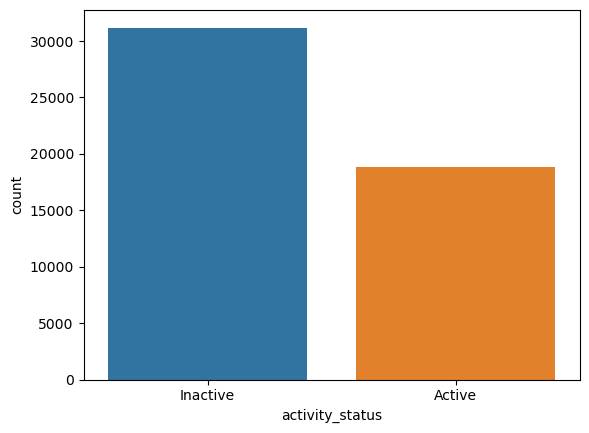

In [30]:
#Presentation order
order = ['Inactive', 'Active']  

sns.countplot(data=df, x='activity_status', order=order)

plt.show()


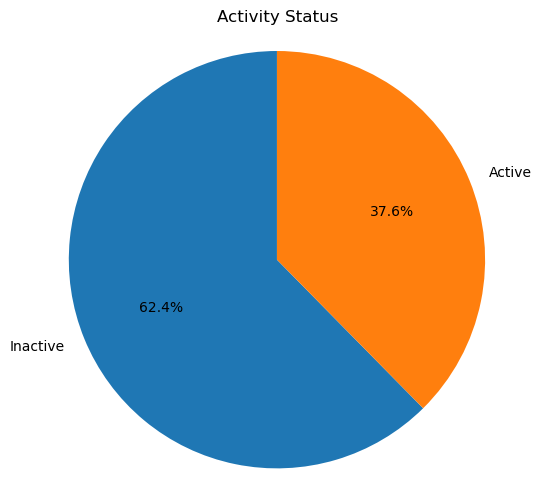

In [31]:
#Count the number of active and inactive users
activity_counts = df['activity_status'].value_counts()

#Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Activity Status')
plt.axis('equal') 

plt.show()

**Insight:** Activity status based on last trip date reveals an active population of 37.6%. Suggesting that the population of the dataset is slightly skewed towards inactive memebers. 

In [32]:
#Add a new column 'membership_length'
df['membership_length'] = (df['last_trip_date'] - df['signup_date']).dt.days

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status,membership_length
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,Active,143
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,Inactive,96
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,Inactive,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,Active,170
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,Inactive,47


In [33]:
df['membership_length'].describe()

count    50000.000000
mean        92.790100
std         62.129822
min          0.000000
25%         27.000000
50%        110.000000
75%        150.000000
max        181.000000
Name: membership_length, dtype: float64

<AxesSubplot:xlabel='membership_length', ylabel='Count'>

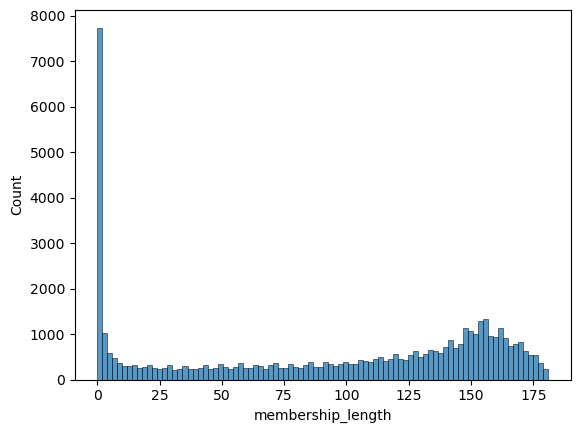

In [34]:
sns.histplot(data=df, x='membership_length', bins=90)

<AxesSubplot:xlabel='membership_length', ylabel='Count'>

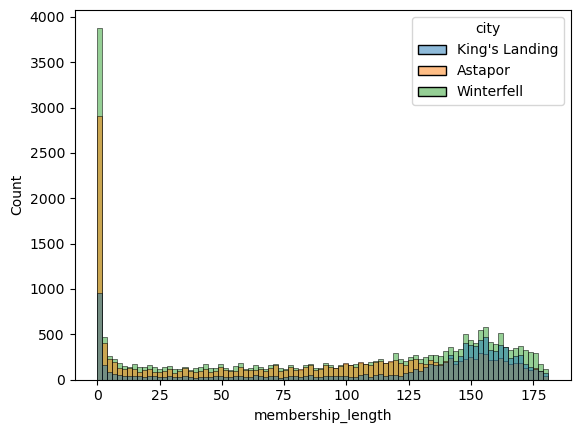

In [35]:
sns.histplot(data=df, x='membership_length', bins=90, hue='city')

**Insight:** The analysis of ridership length uncovers a fascinating bimodal distribution, indicating the presence of two distinct clusters within the user base. The first cluster exhibits a notable spike, prominently concentrated around the one-day mark, while the second cluster reappears with remarkable density at approximately 160 days.

This intriguing pattern hints at the need for a nuanced approach to user retention strategies. Specifically, it suggests the importance of addressing both early engagement efforts, aimed at enhancing user commitment during their initial interaction with the program, as well as more extended-term strategies to keep users engaged and active over the longer span of 160 days.

To harness the full potential of this insight, it may be beneficial to delve deeper into each cluster, understanding the distinct behaviors, preferences, and pain points of users in these two groups. Tailoring retention initiatives to suit the needs of users within each cluster could be a key strategy for optimizing the program's long-term success.

In [36]:
#Add a new column 'six_month_activity_status'
df['six_month_activity_status'] = df['membership_length'] >= 150

#Convert boolean values to 'Active' or 'Inactive'
df['six_month_activity_status'] = df['six_month_activity_status'].map({True: 'Active', False: 'Inactive'})

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status,membership_length,six_month_activity_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,Active,143,Inactive
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,Inactive,96,Inactive
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,Inactive,1,Inactive
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,Active,170,Active
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,Inactive,47,Inactive


In [37]:
df['six_month_activity_status'].describe()

count        50000
unique           2
top       Inactive
freq         37286
Name: six_month_activity_status, dtype: object

In [38]:
#Count the number of rows where 'membership_length' is >= 150
count_greater_than_150 = (df['membership_length'] >= 150).sum()

print("Number of memberships with duration >= 150:", count_greater_than_150)

Number of memberships with duration >= 150: 12714


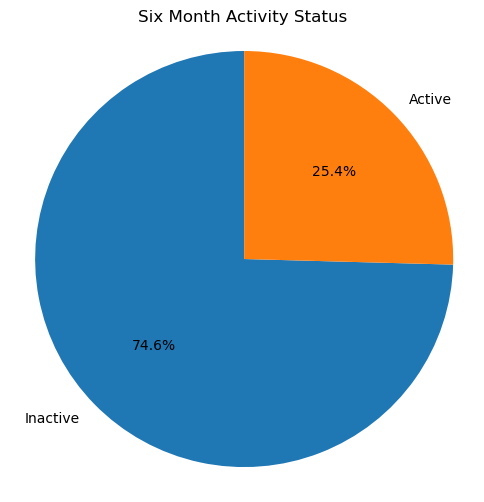

In [39]:
#Count the number of active and inactive users
activity_counts = df['six_month_activity_status'].value_counts()

#Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Six Month Activity Status')
plt.axis('equal') 

plt.show()

<AxesSubplot:xlabel='six_month_activity_status', ylabel='count'>

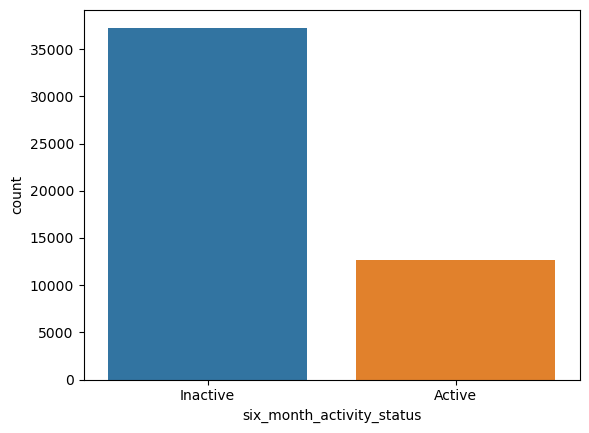

In [40]:
sns.countplot(data=df, x='six_month_activity_status', order=order)

**Insight** When plotting the six-month activity status, it becomes evident that only 25.4% of the dataset corresponds to active riders. This observation highlights a significant imbalance in favor of inactive riders and indicates the potential need for rebalancing the dataset or adjusting class weights to enhance the accuracy of predicting six-month retainership." 

<AxesSubplot:xlabel='city', ylabel='count'>

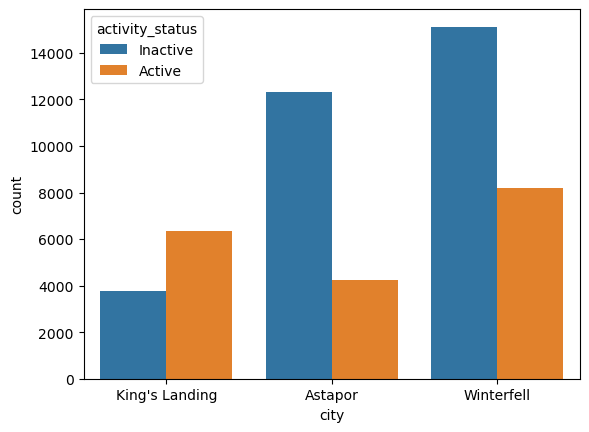

In [41]:
sns.countplot(data=df, x='city', hue='activity_status', hue_order=order)

<AxesSubplot:xlabel='city', ylabel='count'>

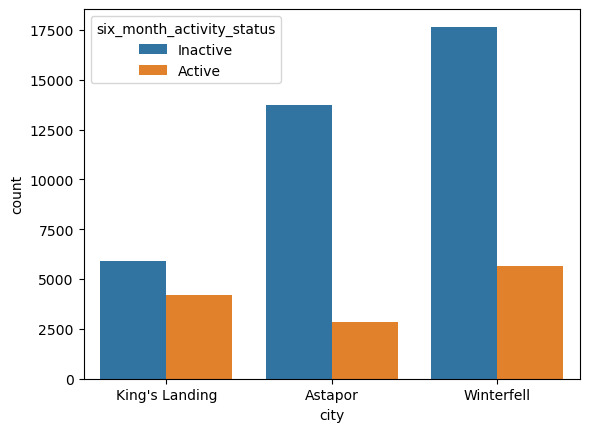

In [42]:
sns.countplot(data=df, x='city', hue='six_month_activity_status', hue_order=order)

**Insight** While overall ridership seems to be highest in Winterfell, the proportion of active ridership in King's Landing is the most balanced. This suggests that efforts in Winterfell to encourage ridership may be the most effective, while focusing on retaining riders in King's Landing could be more impactful.

### Preprocessing

In [43]:
df = df.drop(columns = ['last_trip_date', 'signup_date', 'membership_length'])

In [44]:
#Replace avg_rating_by_driver null values with mean
mean = df['avg_rating_by_driver'].mean()
rating = lambda row: mean if np.isnan(row) else row
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].apply(rating)

#Replace avg_rating_of_driver null values with mean
mean = df['avg_rating_of_driver'].mean()
rating = lambda row: mean if np.isnan(row) else row
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].apply(rating)

In [45]:
#Replace phone null values with Other
other = lambda row: "Other" if type(row) != str else row
df["phone"] = df["phone"].apply(other)

print(df["phone"].unique())

['iPhone' 'Android' 'Other']


In [46]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
avg_rating_of_driver         0
avg_surge                    0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
activity_status              0
six_month_activity_status    0
dtype: int64

In [47]:
#Mapping varibles for preprocessing
df['ultimate_black_user'] = df['ultimate_black_user'].map({False:0, True:1}).astype('category')
df['activity_status'] = df['activity_status'].map({'Inactive':0, 'Active':1}).astype('category')
df['six_month_activity_status'] = df['six_month_activity_status'].map({'Inactive':0, 'Active':1}).astype('category')
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status,six_month_activity_status
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0,0


In [48]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
avg_rating_of_driver         0
avg_surge                    0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
activity_status              0
six_month_activity_status    0
dtype: int64

In [49]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

display(X_train.head())
display(y_train.head())

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status
45139,Winterfell,14,5.0,1.04,iPhone,4.4,1,75.6,5.21,4.7,1
9901,Astapor,11,4.3,1.08,iPhone,10.0,0,60.0,2.25,4.7,0
26038,Astapor,5,4.8,1.57,iPhone,28.6,0,14.3,3.11,4.6,0
49163,Astapor,1,4.5,1.00,iPhone,0.0,0,50.0,1.32,5.0,0
38957,Winterfell,17,3.2,1.00,Android,0.0,1,40.0,4.36,4.7,0


45139    1
9901     0
26038    0
49163    0
38957    0
Name: six_month_activity_status, dtype: category
Categories (2, int64): [0, 1]

In [50]:
from imblearn.under_sampling import RandomUnderSampler
# Initialize RandomOverSampler
ros = RandomUnderSampler(random_state=0)

# Resample the dataset
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


### Modeling

**Approach:** To meet the binary classification requirement for addressing the inquiries at hand, I am optting for building a model using powerful classification algorithms such as logistic regression, random forest, or gradient boosting. These models offer simplicity, robustness, enhanced flexibility, and interpretability over models such as RNNS or LSTMs which would may require more data and computational resources. Utilizing one of the aformentioned classification algorithms, in turn, would enable us to recommend strategies for improving long-term rider retention at Ultimate.

While logistic regression may provide the highest level of interpretability among the three models mentioned, random forest offers superior flexibility and robustness compared to the other two. Additionally, it provides valuable insights, including feature importance, which is highly beneficial for implementation and analysis purposes.

**Concerns:** General concerns regarding class imbalance arose during the Exploratory Data Analysis (EDA) phase, as it was revealed that the current dataset is skewed towards inactive riders. To address this concern, we have taken steps to account for it by undersampling the training data, rebalancing the dataset for implementation into the machine learning algorithms. Additionally, we will remain vigilant about concerns related to generalization and feature selection. These aspects will be assessed after the initial model implementation by utilizing key metrics such as accuracy and the F1 score.

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Numerical features pipeline
numeric_features = ['trips_in_first_30_days', 'avg_rating_by_driver', 'avg_surge', 'surge_pct', \
                    'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
numeric_transformer = [('scaler', StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

#Categorical features pipeline
categorical_features = ['city', 'phone', 'ultimate_black_user', 'activity_status']
categorical_transformer = [('encoder', OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

#Pipeline divernce
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features), \
                  ('cat', categorical_transformer, categorical_features)])

#Adding random forest classifier
pipeline = Pipeline(steps=[('pre', preprocessor), \
                           ('rf', RandomForestClassifier(random_state = 42))])

#Grid search parameters
params = {'rf__n_estimators' : [10, 25, 50, 75, 100],
          'rf__max_depth' : [5, 10, 15, 20]}

#Fitting the pipeline to the grid search
cv = GridSearchCV(pipeline, param_grid=params, cv=5)
cv.fit(X_resampled, y_resampled)

print(cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['trips_in_first_30_days',
                                                                          'avg_rating_by_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'weekday_pct',
                                                                          'avg_dist',
                                                                          'avg_rating_by_driver'

In [52]:
print(f'Best parameters: {cv.best_params_}')
print(f'Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%')

Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 10}
Training accuracy score from tuned model:        91.4%


In [53]:
from sklearn import metrics

y_pred = cv.predict(X_test)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_f1_score = metrics.f1_score(y_test, y_pred)

print(f'Model accuracy: {test_accuracy*100:.2f}%')
print(f'Model F1 Score: {test_f1_score:.2f}')

Model accuracy: 87.79%
Model F1 Score: 0.81


In [54]:
pipeline.fit(X_train, y_train)

weights = pipeline.named_steps['rf'].feature_importances_

print(weights)

[0.05208121 0.03039592 0.04152162 0.04570855 0.07967761 0.15634298
 0.03656224 0.00731604 0.00915068 0.00709353 0.00742961 0.00112623
 0.00653701 0.00686632 0.00751906 0.21343707 0.2912343 ]


In [55]:
#Replicating pipeline numeric_transformer
num_cols = df[numeric_features].columns
num_cols = num_cols.tolist()

#Replicating pipeline categorical_transformer
cat_cols = pd.get_dummies(df[categorical_features]).columns
cat_cols = cat_cols.tolist()

#Adding column names
cols = num_cols + cat_cols

#Zipping column names to weights list
feature_importance = zip(cols, weights)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f'Weight: {j:.3f} | Feature: {i}')

Weight: 0.291 | Feature: activity_status_1
Weight: 0.213 | Feature: activity_status_0
Weight: 0.156 | Feature: avg_dist
Weight: 0.080 | Feature: weekday_pct
Weight: 0.052 | Feature: trips_in_first_30_days
Weight: 0.046 | Feature: surge_pct
Weight: 0.042 | Feature: avg_surge
Weight: 0.037 | Feature: avg_rating_by_driver
Weight: 0.030 | Feature: avg_rating_by_driver
Weight: 0.009 | Feature: city_King's Landing
Weight: 0.008 | Feature: ultimate_black_user_1
Weight: 0.007 | Feature: phone_Android
Weight: 0.007 | Feature: city_Astapor
Weight: 0.007 | Feature: city_Winterfell
Weight: 0.007 | Feature: ultimate_black_user_0
Weight: 0.007 | Feature: phone_iPhone
Weight: 0.001 | Feature: phone_Other


Leveraging the feature importance insights from the model can provide valuable guidance to Ultimate for improving long-term rider retention. 

1. **Activity Status**: While the activity status features have the highest importance weights, this metric is not particularly useful for leveraging insights. This component merely specifies whether the rider has been active in the last 30 days, and while it is a requirement for six-month retention, it does not provide any valuable insights into the factors that may have influenced the user to remain active.

2. **Avg_Dist and Weekday_Pct**: Features like `avg_dist` and `weekday_pct` also have notable importance. Ultimate can use this information to optimize pricing and incentive strategies for riders who tend to have longer average distances or higher weekday usage. Special promotions or loyalty programs on weekdays may help retain these riders.

3. **Surge Pricing and Avg_Surge**: The impact of `surge_pct` and `avg_surge` suggests that managing surge pricing during peak hours is crucial for rider retention. Balancing pricing to maintain affordability during peak times while ensuring driver availability is essential to keep riders engaged.

4. **Driver Ratings and City Choice**: Features related to driver ratings and city choices (`avg_rating_by_driver`, `city_King's Landing`, etc.) also play a role. Ultimate can work on improving the driver-rider experience and consider city-specific marketing strategies to retain riders in different locations.

5. **Device and Ultimate Black Usage**: Features like `phone_Android`, `phone_iPhone`, and `ultimate_black_user_1` offer minimal insights into rider preferences. Ultimate can optimize its app for different devices and tailor promotions for Ultimate Black users to enhance their loyalty. However, any incentives to these feature may prove to be least affective in overall retainership.

In summary, leveraging these insights allows Ultimate to adopt a data-driven approach for rider retention. By understanding the drivers behind rider behavior and preferences, Ultimate can implement targeted marketing campaigns, pricing adjustments, and service improvements to enhance long-term rider satisfaction and loyalty.